# Comparación de los modelos obtenidos

En este cuaderno vamos a estudiar los distintos modelos que hemos entrenado para ver cuáles tienen mejor precisión.

In [32]:
# importamos las librerias de deep learning
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

# librerias para limpiar los datos
import matplotlib.pyplot as plt
import pandas as pd
import string
import numpy as np
import os

# librerias para preparar los datos para entrenar y visualizar resultados
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# guardar y cargar modelos
from joblib import dump, load
import pickle

#tf.get_logger().setLevel('ERROR')

In [28]:
df = pd.read_csv('Data/df_limpio.csv')
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'].to_numpy(), test_size = 0.3, stratify = df['label'].to_numpy(), random_state = 42)

In [30]:
# creamos una lista para contener los datos
data_for_df = []
predict_data = []

# iteramos para obtener cada modelo y predecir
for model_name in os.listdir('models'):
    # cargamos el modelo
    model = tf.keras.models.load_model(f'models/{model_name}', compile=False)

    # predecimos y guardamos la predicción entera
    yhat = model.predict(X_test).flatten()
    yhat = np.where(yhat > 0.5, 1, 0)
    predict_data.append(yhat)

    # obtenemos métricas sobre la predicción y las guardamos
    extra_name, model_type = model_name.split('smallbert', maxsplit=1)
    model_type = 'smallbert' + model_type
    data_for_df.append([model_type, 
                 extra_name, 
                 accuracy_score(y_test, yhat),
                 precision_score(y_test, yhat, average = "macro"),
                 recall_score(y_test, yhat, average = "macro"),
                 jaccard_score(y_test, yhat, average = "macro"),
                 f1_score(y_test, yhat, average = "macro")])
    

671/671 [==============================] - 110s 164ms/step


2024-01-11 21:27:43.648970: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-01-11 21:27:43.649000: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-01-11 21:27:43.649049: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.


671/671 [==============================] - 155s 230ms/step


2024-01-11 21:30:44.384887: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.
2024-01-11 21:30:44.384971: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 93763584 exceeds 10% of free system memory.


671/671 [==============================] - 163s 242ms/step


In [31]:
df = pd.DataFrame(data_for_df, columns = ['model_name', 'extra_name', 'acc', 'precision', 'recall', 'jaccard', 'f1_score'])
df.to_csv('resultados.csv', index=False)

In [97]:
df = pd.read_csv('resultados.csv')

In [117]:
df.sort_values(by = 'acc', ascending=False)

,model_name,extra_name,acc,precision,recall,jaccard,f1_score
7,smallbert_en_uncased_L-6_H-768_A-12,nolimpio_,0.991194,0.991228,0.991156,0.982533,0.991189
9,smallbert_en_uncased_L-8_H-512_A-8,nolimpio_,0.989050,0.989017,0.989081,0.978330,0.989046
6,smallbert_en_uncased_L-4_H-768_A-12,nolimpio_,0.982248,0.982374,0.982544,0.965113,0.982247
3,smallbert_en_uncased_L-8_H-128_A-2,nolimpio_,0.976563,0.976651,0.976475,0.954174,0.976549
1,smallbert_en_uncased_L-6_H-128_A-2,NaN,0.963564,0.963515,0.963600,0.929667,0.963551
5,smallbert_en_uncased_L-6_H-128_A-2,nolimpio_,0.963564,0.963515,0.963600,0.929667,0.963551
8,smallbert_en_uncased_L-6_H-128_A-2,nopunct_,0.940639,0.940579,0.940699,0.887904,0.940623
4,smallbert_en_uncased_L-6_H-128_A-2,not_trainable_nolimpio_,0.607585,0.713776,0.614679,0.402775,0.559575
0,smallbert_en_uncased_L-6_H-128_A-2,doscolumnas_nolimpio_,0.500466,0.747504,0.510591,0.258094,0.351849
2,smallbert_en_uncased_L-6_H-128_A-2,title_nolimpio_,0.500140,0.280992,0.490030,0.250558,0.334552


Con este código guardamos la lista de datos de las predicciones para poder cargarlas más adelante. 
```python
with open("predict_data", "wb") as file:
    pickle.dump(predict_data, file) 
```

In [34]:
# con este código recuperamos los datos de las predicciones sin ejecutarlo
with open("predict_data", "rb") as file: 
    predict_data = pickle.load(file)

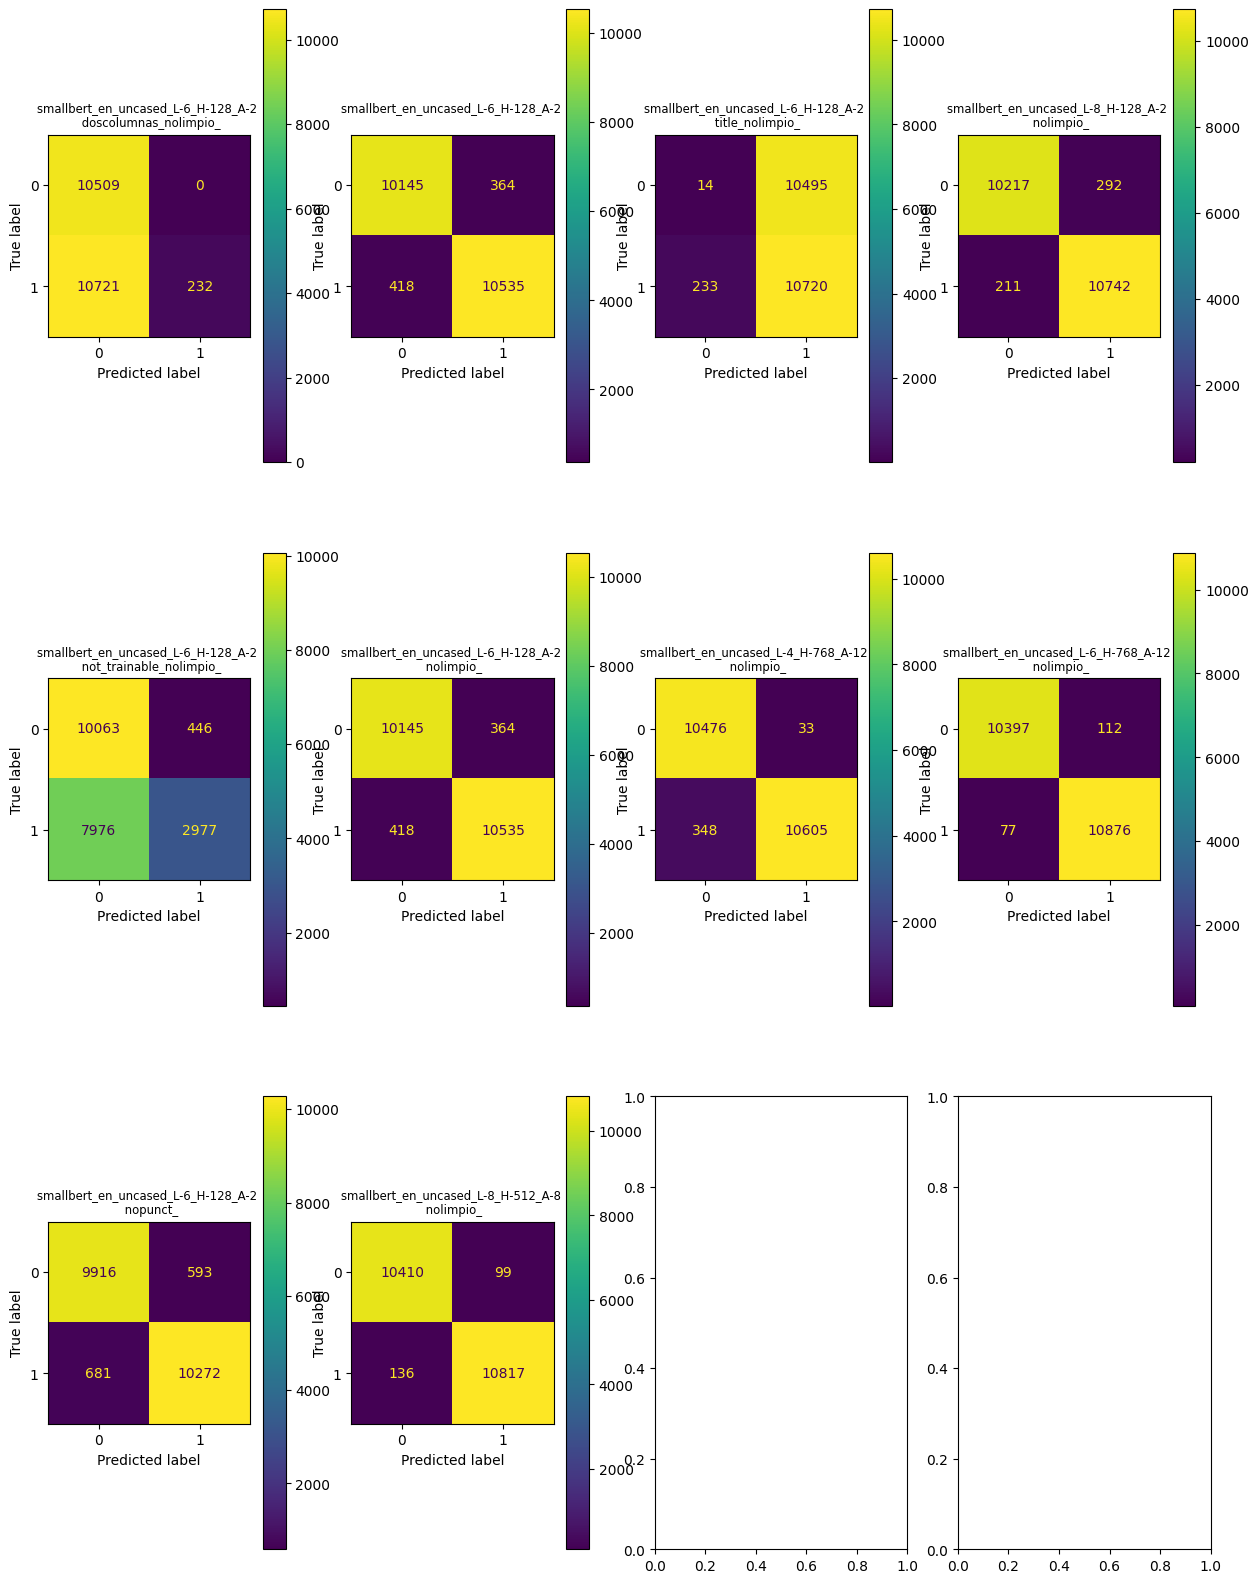

In [116]:
cols = 4
rows = len(predict_data)//4 +1

fig, axs = plt.subplots(rows, cols, figsize = (15,20))
axs = axs.flatten()
names = df['model_name'].to_numpy() +' \n '+ df['extra_name'].fillna('').to_numpy()


for ax, yhat, name in zip(axs, predict_data, names):
    cm = confusion_matrix(y_test, yhat)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format = 'd', ax= ax)
    ax.set_title(name, fontsize='small')